In [ ]:
#Data Cleaning Exercise
#Data set --> https://www.kaggle.com/datasets/shivamb/netflix-shows

In [30]:
import pandas as pd

df = pd.read_csv('/kaggle/input/netflix-shows/netflix_titles.csv')

print('First few data', df.head())

print('Information',df.info())

First few data   show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 2

In [6]:
df.shape

(8807, 12)

In [31]:
#Checking no of null values per column

print('Null Values', df.isnull().sum())

Null Values show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64


In [33]:
#You can see that director, cast, date_added, country, rating, duration has null values
#date_added is Object --> Let's convert it into datetime

df['director'] = df['director'].fillna("Unknown")
df['cast'] = df['cast'].fillna('Unknown')
df['country'] = df['country'].fillna('Unknown')

print('data type of date_added', df['date_added'])

df['date_added'] = df['date_added'].str.strip()
df['date_added'] = pd.to_datetime(df['date_added'],format="%B %d, %Y")

data type of date_added 0       September 25, 2021
1       September 24, 2021
2       September 24, 2021
3       September 24, 2021
4       September 24, 2021
               ...        
8802     November 20, 2019
8803          July 1, 2019
8804      November 1, 2019
8805      January 11, 2020
8806         March 2, 2019
Name: date_added, Length: 8807, dtype: object


In [34]:
#Duration are mixed up, such as '90 min' and '1 Season'

df[['duration_int', 'duration_type']] = df['duration'].str.extract('(\d+)\s*(\w+)')
df['duration_int'] = pd.to_numeric(df['duration_int'])

In [35]:
df['country'] = df['country'].apply(lambda x: x.split(',')[0] if pd.notnull(x) else 'Unknown')

In [37]:
df.drop_duplicates(inplace=True)

In [38]:
print(df['type'].unique())
print(df['rating'].unique())

df['rating'] = df['rating'].replace(['UR', 'NR', 'Not Rated'], 'Unrated')

['Movie' 'TV Show']
['PG-13' 'TV-MA' 'PG' 'TV-14' 'TV-PG' 'TV-Y' 'TV-Y7' 'R' 'TV-G' 'G'
 'NC-17' '74 min' '84 min' '66 min' 'NR' nan 'TV-Y7-FV' 'UR']


# To Find:

## Understanding what content is available in different countries
## Identifying similar content by matching text-based features
## Network analysis of Actors / Directors and find interesting insights
## Does Netflix has more focus on TV Shows than movies in recent years.

# For: Understanding what content is available in different countries, we need to find answers to the following:

## Which countries have the most Netflix content?
## Are some countries biased toward TV Shows or Movies?
## Which genres dominate per country?

<Axes: xlabel='country'>

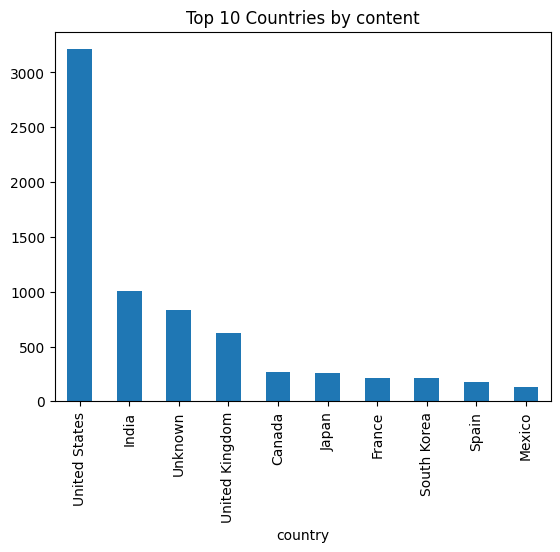

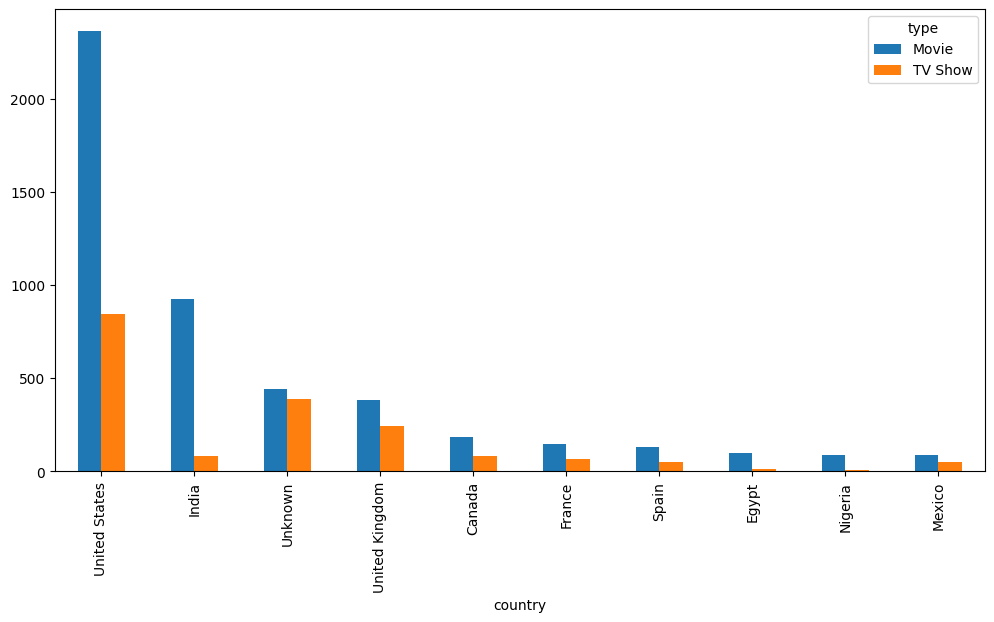

In [39]:
#count content per country

df['country'].value_counts().head(10).plot(kind='bar', title='Top 10 Countries by content')

#Content type per country

type_by_country = df.groupby(['country', 'type']).size().unstack().fillna(0)
type_by_country.sort_values('Movie', ascending=False).head(10).plot(kind='bar', figsize=(12,6))

# For, Identifying similar content by matching text-based features, we need to find out the following:

## Can we recommend similar titles based on genre, description, or cast?
## Which titles are semantically similar?

### Use description, listed_in, and optionally cast

### Convert text into numerical format (TF-IDF)

### Use cosine similarity to find closest matches

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

#filling missing description
df['description'] = df['description'].fillna('')

# Use TF-IDF on descriptions
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['description'])

# Compute similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Example: Find similar content to "Stranger Things"
index = df[df['title'] == 'Stranger Things'].index[0]
similar_indices = cosine_sim[index].argsort()[-6:-1][::-1]
df.iloc[similar_indices][['title', 'description']]

,title,description
4733,Rowdy Rathore,A con man uncovers a deadly secret and must sa...
1240,Safe Haven,When a mysterious woman arrives in a small Nor...
1487,Sakho & Mangane,A by-the-book police captain and a brash young...
8198,The Autopsy of Jane Doe,A father-son team of small-town coroners perfo...
2419,Big Stone Gap,A single middle-aged woman who has lived her w...


# For, Network analysis of Actors / Directors and find interesting insights

## Which actors/directors appear together most often?
## Are there highly connected individuals in the network?

In [49]:
import networkx as nx
from itertools import combinations

#Build graph from cast

G = nx.Graph()


for cast in df['cast'].dropna():
    actors = [a.strip() for a in cast.split(',')]
    for pair in combinations(actors,2):
        G.add_edge(*pair)

# Top 10 most connected actors
degree_dict = dict(G.degree())
sorted_actors = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)
print(sorted_actors[:10])

[('Anupam Kher', 273), ('Samuel L. Jackson', 239), ('Takahiro Sakurai', 228), ('Fred Tatasciore', 226), ('Yuichi Nakamura', 223), ('Yuki Kaji', 220), ('Shah Rukh Khan', 210), ('Fred Armisen', 209), ('Akshay Kumar', 193), ('Katsuyuki Konishi', 191)]


# Does Netflix focus more on TV Shows than Movies in recent years?

## Is there a trend showing more TV shows being added over time?
## Are TV shows growing faster than movies?

<Axes: title={'center': 'Netflix Content Added by Year (TV Shows vs Movies)'}, xlabel='year_added'>

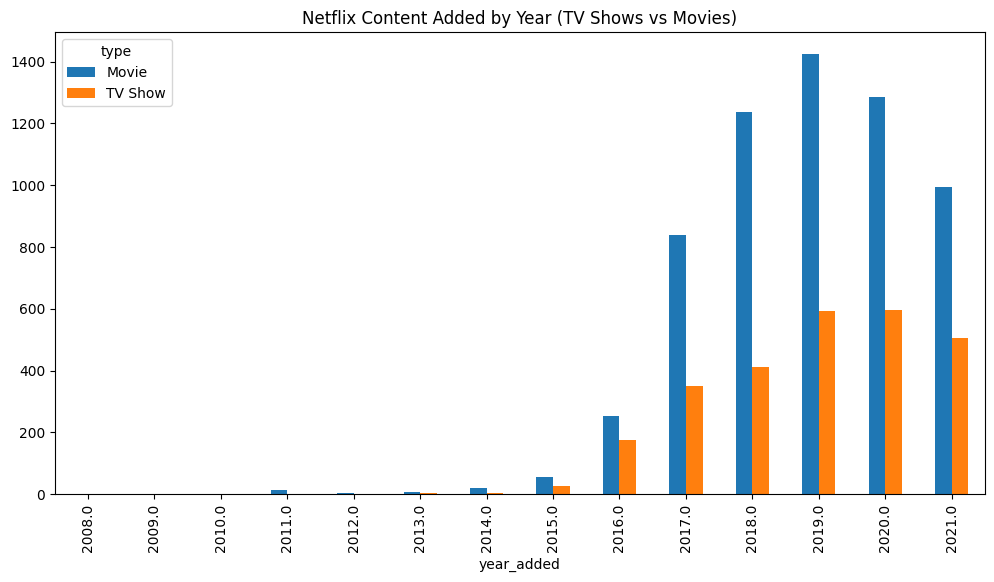

In [52]:
df['year_added'] = df['date_added'].dt.year

# Group by year and type
trend = df.groupby(['year_added', 'type']).size().unstack().fillna(0)

# Plot
trend.plot(kind='bar', figsize=(12,6), title='Netflix Content Added by Year (TV Shows vs Movies)')